# Precision calibration of Spectrograph for near star exo-planet searches

The following is an attempt at providing a precision calibration of a spectrogram over long periods of time (5+ years) based on ~8000 equidistant lines from a laser distorted by the spectrograph itself. It is an experimental attempt

   WAVELENGTH      DOUBLE    Array[7920]
   SPECTRUM        DOUBLE    Array[7920]
   UNCERTAINTY     DOUBLE    Array[7920]  
   CONTINUUM       DOUBLE    Array[7920]
   OFFSET          DOUBLE    Array[7920]
   OFFSET_UNCERTAINTY
                   DOUBLE    Array[7920]
   N_PIXELS        INT       Array[7920]
   REDUCED_CHI     DOUBLE    Array[7920]
   CONTINUUM_MASK  BYTE      Array[7920]
   PIXEL_MASK      BYTE      Array[7920]
   TELLURICS       DOUBLE    Array[7920]
   ORDER           INT            160
   BARY_WAVELENGTH DOUBLE    Array[7920]
   BLAZE           DOUBLE    Array[7920]
   BARY_EXCALIBUR  DOUBLE    Array[7920]
   EXCALIBUR       DOUBLE    Array[7920]
   EXCALIBUR_MASK  BYTE      Array[7920]
   

Fits -> Classical correction, missing all information about offsets, process, and tellurics.
FFT -> NN -> 
Spectral GNN -> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
import math
from astropy.io import fits
import iminuit
from iminuit import Minuit
import sys
from astropy.utils.data import get_pkg_data_filename
from pylab import *

plt.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")
#plt.rc("text", usetex=True)

save_plots = True

print(iminuit.__version__)

2.8.4


In [2]:
# sys.path.append('/Users/petersen/Teaching/AppliedStatistics2020/AppStat2020_InstructorFolder/External_Functions/')
sys.path.append('/Users/jakobharteg/Github/MyAppStat/')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

***

## Read the data:

Filename: expres_tp/LFC_200907.1063.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (7920, 86)   float64   
  1  optimal       1 BinTableHDU     77   86R x 16C   [7920D, 7920D, 7920D, 7920D, 7920D, 7920D, 7920I, 7920D, 7920D, 7920L, 7920D, I, 7920D, 7920D, 7920D, 7920L]   
  Length of data vector (spectrum): 7920
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[6139.51963463 6139.53379276 6139.54795009 ... 6229.74600114 6229.75483676
 6229.7636717 ]


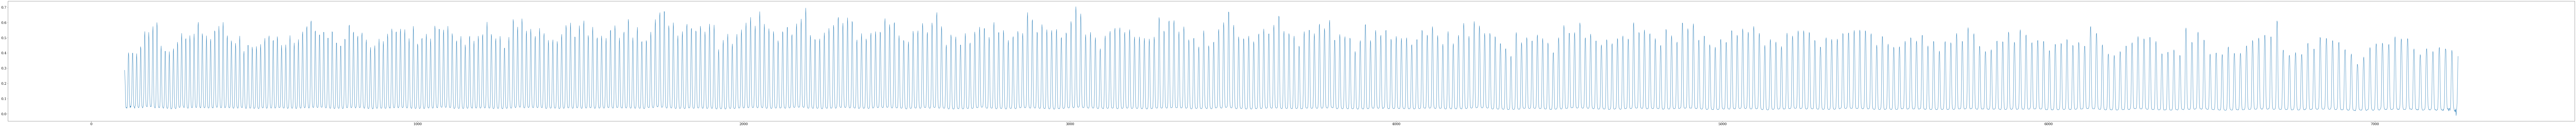

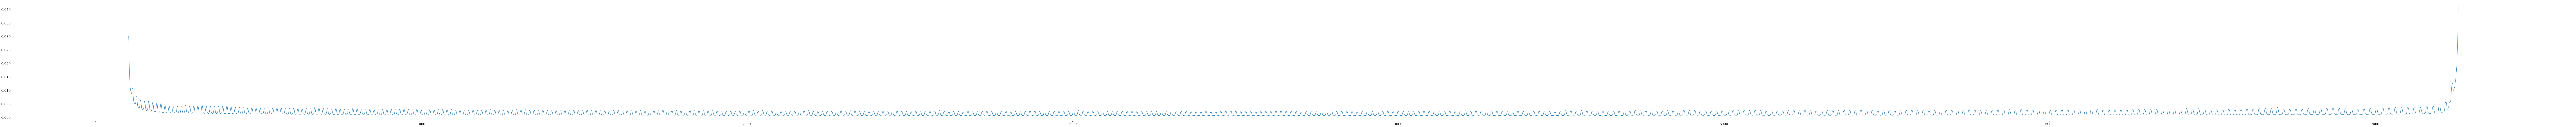

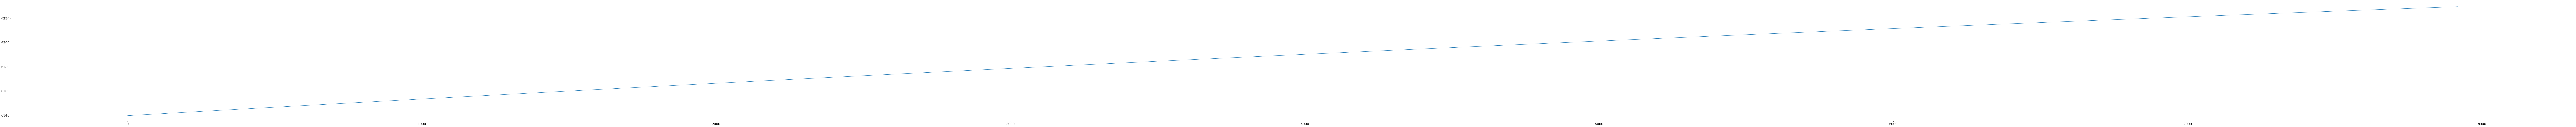

In [3]:
# Read file from Lars:
filename = r"expres_tp/LFC_200907.1063.fits"

hdu1 = fits.open(filename)
# fits.info(hdu1)
hdu1.info()

# hdr = hdul[1].header
# print(repr(hdr1))

data = hdu1[1].data.copy()

Nspecline = 61

# data_np = np.array(data['spectrum'][Nspecline])
Nspec = len(data['spectrum'][Nspecline])
print(f"  Length of data vector (spectrum): {Nspec:d}")

# Spectrum plot:
fig, ax = plt.subplots(figsize=(250,12))
ax.plot(data['spectrum'][Nspecline])
fig.savefig("test_realdata.png")
print(data['spectrum'][Nspecline])

# Spectrum uncertainty plot:
fig, ax = plt.subplots(figsize=(250,12))
ax.plot(data['uncertainty'][Nspecline])
fig.savefig("test_realdata_uncertainty.png")
print(data['uncertainty'][Nspecline])

# Wavelength plot:
fig, ax = plt.subplots(figsize=(250,12))
ax.plot(data['wavelength'][Nspecline])
fig.savefig("test_realdata_wavelength.png")
print(data['wavelength'][Nspecline])

In [4]:
# Check for NaNs and find working range: 
NpeaksMax = 10000
RealValueEncountered = False
Nnans_begin = 0
Nnans_end = 0
vspec  = [0, 0, 0, 0]
vespec = [0, 0, 0, 0]
vwave  = [0, 0, 0, 0]
peak_specs  = []
peak_especs = []
peak_waves  = []
peak_spec   = []
peak_espec  = []
peak_wave   = []
PeakLengths = []

specs  = np.array(data['spectrum'][Nspecline])
especs = np.array(data['uncertainty'][Nspecline])
waves  = np.array(data['wavelength'][Nspecline])

print(specs.shape, especs.shape, waves.shape)

# for count, value in enumerate(spec) :
for spec, espec, wave in zip(specs, especs, waves):
    
    # First check for NaNs:
    if math.isnan(spec) :
        if (not RealValueEncountered) :
            Nnans_begin += 1
        else :
            Nnans_end +=1

    # If good, then find peaks:
    else :
        # First, save the values:
        vspec.append(spec)
        vespec.append(espec)        
        vwave.append(wave)
        RealValueEncountered = True

        # If starting on a new peak, save the current one (selection to be improved):
        if (vspec[-1] > vspec[-2] and vspec[-2] < vspec[-3] and vspec[-3] < vspec[-4] and len(peak_specs) < NpeaksMax) :
            peak_specs.append(peak_spec)
            peak_especs.append(peak_espec)
            peak_waves.append(peak_wave)
            PeakLengths.append(len(peak_spec))
            peak_spec = []
            peak_espec = []
            peak_wave = []

        # Put value into peak array:
        peak_spec.append(spec)
        peak_espec.append(espec)
        peak_wave.append(wave)

        
print("  Number of non-NaN entries:", len(vspec))
print("  Number of NaN entries before valid range:", Nnans_begin)
print("  Number of NaN entries after valid range:", Nnans_end)
print("  Number of peaks:", len(peak_specs))

# Nexample = 53
Nexample = 50
print("  Number of entries in example peak: ", len(peak_specs[Nexample]))
for i in range(len(peak_specs[Nexample])) :
    print(f"  i: {i:2d}    wave = {peak_waves[Nexample][i]:8.3f}   spec = {peak_specs[Nexample][i]:6.4f} +- {peak_especs[Nexample][i]:6.4f}")


(7920,) (7920,) (7920,)
  Number of non-NaN entries: 7158
  Number of NaN entries before valid range: 102
  Number of NaN entries after valid range: 664
  Number of peaks: 500
  Number of entries in example peak:  13
  i:  0    wave = 6149.703   spec = 0.0412 +- 0.0010
  i:  1    wave = 6149.716   spec = 0.0687 +- 0.0013
  i:  2    wave = 6149.730   spec = 0.1807 +- 0.0020
  i:  3    wave = 6149.744   spec = 0.3824 +- 0.0028
  i:  4    wave = 6149.757   spec = 0.5393 +- 0.0033
  i:  5    wave = 6149.771   spec = 0.5358 +- 0.0033
  i:  6    wave = 6149.784   spec = 0.3746 +- 0.0028
  i:  7    wave = 6149.798   spec = 0.1706 +- 0.0019
  i:  8    wave = 6149.811   spec = 0.0642 +- 0.0012
  i:  9    wave = 6149.825   spec = 0.0442 +- 0.0011
  i: 10    wave = 6149.839   spec = 0.0359 +- 0.0010
  i: 11    wave = 6149.852   spec = 0.0357 +- 0.0010
  i: 12    wave = 6149.866   spec = 0.0346 +- 0.0010


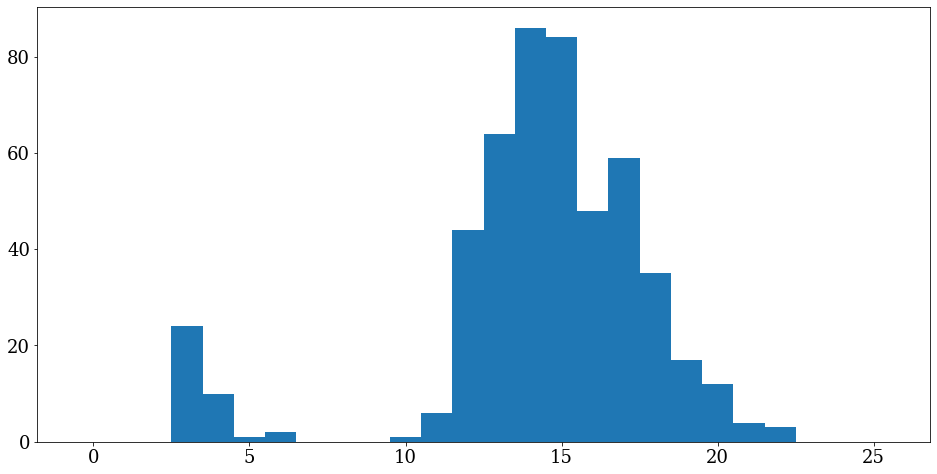

In [5]:
# Show the distribution of number of data points in a peak (cross check of peak selection algorithm):
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
ax1.hist(PeakLengths, bins=26, range=(-0.5, 25.5))
plt.show()

## Wavelet peak fit approach:

In [6]:
from scipy import signal
xs = np.arange(0, np.pi, 0.05)
data = np.sin(xs)
print(data)
peakind = signal.find_peaks_cwt(data, np.arange(1,10))
peakind, xs[peakind], data[peakind]

[0.         0.04997917 0.09983342 0.14943813 0.19866933 0.24740396
 0.29552021 0.34289781 0.38941834 0.43496553 0.47942554 0.52268723
 0.56464247 0.60518641 0.64421769 0.68163876 0.71735609 0.75128041
 0.78332691 0.8134155  0.84147098 0.86742323 0.89120736 0.91276394
 0.93203909 0.94898462 0.96355819 0.97572336 0.98544973 0.99271299
 0.99749499 0.99978376 0.9995736  0.99686503 0.99166481 0.98398595
 0.97384763 0.9612752  0.94630009 0.92895972 0.90929743 0.88736237
 0.86320937 0.83689879 0.8084964  0.7780732  0.74570521 0.71147335
 0.67546318 0.6377647  0.59847214 0.55768372 0.51550137 0.47203054
 0.42737988 0.38166099 0.33498815 0.28747801 0.23924933 0.19042265
 0.14112001 0.09146464 0.04158066]


(array([32]), array([1.6]), array([0.9995736]))

In [7]:
from scipy import signal
y = np.array(vspec[4000:4500])
peakind = signal.find_peaks_cwt(y, np.arange(10,22))
print(peakind)
# peakind, vwave[peakind+4000], vspec[peakind+4000] # NOTE this crashes 

[ 14  62 109 142 206 271 303 336 416 466 496]


## Fitting single (example) peak:

In [8]:
Minuit.print_level = 2    # Printing result of the fit
Minuit.errordef    = 1    # Corresponding to Chi2 calculation

x = np.array(peak_waves[Nexample])
y = np.array(peak_specs[Nexample])
ey = np.array(peak_especs[Nexample])

# Fitting functions:
def func_GaussConst(x, A, mu, sigma, C) :
    return A * np.exp(-0.5 * ((x-mu)/sigma)**2)  +  C

def func_GaussGaussConst(x, A, mu, sigma1, B, sigma2, C) :
    return A * np.exp(-0.5 * ((x-mu)/sigma1)**2)  +  B * np.exp(-0.5 * ((x-mu)/sigma2)**2)  +  C

def func_GaussEffConst(x, A, mu, sigma1, B, sigma2, C) :
    return A * np.exp(-0.5 * ((x-mu)/sigma1)**2)  *  (1.0 - B * np.exp(-0.5 * ((x-mu)/sigma2)**2))  +  C

def func_GaussEff2Const(x, A, mu, sigma1, B, C) :
    sigma2 = 0.7667 * sigma1 - 0.1013     # Estimates from scatter plot (with sigma2 floating)
    return A * np.exp(-0.5 * ((x-mu)/sigma1)**2)  *  (1.0 - B * np.exp(-0.5 * ((x-mu)/sigma2)**2))  +  C


# ChiSquare to be minimised (using ExternalFunctions):
# chi2_object = Chi2Regression(fit_function, x, y, ey)

# ChiSquare fit model:
def model_chi2(A, mu, sigma, C) :
    y_fit = func_GaussConst(x, A, mu, sigma, C)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2

def modelGG_chi2(A, mu, sigma1, B, sigma2, C) :
    y_fit = func_GaussGaussConst(x, A, mu, sigma1, B, sigma2, C)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2

def modelEff_chi2(A, mu, sigma1, B, sigma2, C) :
    y_fit = func_GaussEffConst(x, A, mu, sigma1, B, sigma2, C)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2

def modelEff2_chi2(A, mu, sigma1, B, C) :
    y_fit = func_GaussEff2Const(x, A, mu, sigma1, B, C)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2


# Fit peak with a Gaussian:
A_init     = 0.45
mu_init    = np.mean(x)
sigma_init = 0.025
C_init     = 0.02
# minuit = Minuit(chi2_object, pedantic=False, A=2.0, mu=mu_init, sigma=sigma_init, print_level=0)     # External Functions
minuit = Minuit(model_chi2, A=A_init, mu=mu_init, sigma=sigma_init, C=C_init)     # Own alternative

# Perform the actual fit (and save the parameters):
minuit.migrad();                                                  
minuit_output = [minuit.fmin, minuit.params]    # Save the output parameters in case needed
    
# Extract the fitting parameters and their uncertainties:
mu_fit = minuit.values['mu']
sigma_mu_fit = minuit.errors['mu']

Npoints = len(x)
Nvar = 4                            # Number of variables
Ndof_fit = Npoints - Nvar    # Number of degrees of freedom = Number of data points - Number of variables
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom
print(f"  Peak fitted. N = {Npoints:2d}   Chi2 ={Chi2_fit:5.1f}   Wave mean = {mu_fit:8.3f}+-{sigma_mu_fit:5.3f}")

# ------------------------------------------------------------------------------

# Fit peak with a DOUBLE Gaussian:
A_init      = 0.45
mu_init     = np.mean(x)
sigma1_init = 0.02
B_init      = -0.05
sigma2_init = 0.01
C_init      = 0.02
# minuit = Minuit(chi2_object, pedantic=False, A=2.0, mu=mu_init, sigma=sigma_init, print_level=0)     # External Functions
minuitGG = Minuit(modelGG_chi2, A=A_init, mu=mu_init, sigma1=sigma1_init, B=B_init, sigma2=sigma2_init, C=C_init)     # Own alternative

# Perform the actual fit (and save the parameters):
minuitGG.migrad();                                                  
minuitGG_output = [minuitGG.fmin, minuitGG.params]    # Save the output parameters in case needed
    
# Extract the fitting parameters and their uncertainties:
mu_fit = minuitGG.values['mu']
sigma_mu_fit = minuitGG.errors['mu']

Npoints = len(x)
Nvar = 6                            # Number of variables
Ndof_fitGG = Npoints - Nvar         # Number of degrees of freedom = Number of data points - Number of variables
Chi2_fitGG = minuitGG.fval                            # The chi2 value
Prob_fitGG = stats.chi2.sf(Chi2_fitGG, Ndof_fitGG)    # The chi2 probability given N degrees of freedom
print(f"  Peak fitted. N = {Npoints:2d}   Chi2 ={Chi2_fit:5.1f}   Wave mean = {mu_fit:8.3f}+-{sigma_mu_fit:5.3f}")

# ------------------------------------------------------------------------------

# Fit peak with a Gaussian and an EFFICIENCY function:
A_init      = 0.45
mu_init     = np.mean(x)
sigma1_init = 0.02
B_init      = 0.10
sigma2_init = 0.025
C_init      = 0.02
# minuit = Minuit(chi2_object, pedantic=False, A=2.0, mu=mu_init, sigma=sigma_init, print_level=0)     # External Functions
minuitEff = Minuit(modelEff_chi2, A=A_init, mu=mu_init, sigma1=sigma1_init, B=B_init, sigma2=sigma2_init, C=C_init)     # Own alternative

# Perform the actual fit (and save the parameters):
minuitEff.migrad();                                                  
minuitEff_output = [minuitEff.fmin, minuitEff.params]    # Save the output parameters in case needed
    
# Extract the fitting parameters and their uncertainties:
mu_fit = minuitEff.values['mu']
sigma_mu_fit = minuitEff.errors['mu']

Npoints = len(x)
Nvar = 6                            # Number of variables
Ndof_fitEff = Npoints - Nvar         # Number of degrees of freedom = Number of data points - Number of variables
Chi2_fitEff = minuitEff.fval                            # The chi2 value
Prob_fitEff = stats.chi2.sf(Chi2_fitEff, Ndof_fitEff)   # The chi2 probability given N degrees of freedom
print(f"  Peak fitted. N = {Npoints:2d}   Chi2 ={Chi2_fit:5.1f}   Wave mean = {mu_fit:8.3f}+-{sigma_mu_fit:5.3f}")


# ------------------------------------------------------------------------------

# Fit peak with a Gaussian and an EFFICIENCY2 function:
A_init      = 0.45
mu_init     = np.mean(x)
sigma1_init = 0.02
B_init      = 0.10
C_init      = 0.02
# minuit = Minuit(chi2_object, pedantic=False, A=2.0, mu=mu_init, sigma=sigma_init, print_level=0)     # External Functions
minuitEff2 = Minuit(modelEff2_chi2, A=A_init, mu=mu_init, sigma1=sigma1_init, B=B_init, C=C_init)     # Own alternative

# Perform the actual fit (and save the parameters):
minuitEff2.migrad();                                                  
minuitEff2_output = [minuitEff2.fmin, minuitEff2.params]    # Save the output parameters in case needed
    
# Extract the fitting parameters and their uncertainties:
mu_fit = minuitEff2.values['mu']
sigma_mu_fit = minuitEff2.errors['mu']

Npoints = len(x)
Nvar = 5                            # Number of variables
Ndof_fitEff2 = Npoints - Nvar         # Number of degrees of freedom = Number of data points - Number of variables
Chi2_fitEff2 = minuitEff2.fval                            # The chi2 value
Prob_fitEff2 = stats.chi2.sf(Chi2_fitEff2, Ndof_fitEff2)   # The chi2 probability given N degrees of freedom
print(f"  Peak fitted. N = {Npoints:2d}   Chi2 ={Chi2_fit:5.1f}   Wave mean = {mu_fit:8.3f}+-{sigma_mu_fit:5.3f}")


  Peak fitted. N = 13   Chi2 =115.8   Wave mean = 6149.764+-0.000
  Peak fitted. N = 13   Chi2 =115.8   Wave mean = 6149.764+-0.000
  Peak fitted. N = 13   Chi2 =115.8   Wave mean = 6149.764+-0.000
  Peak fitted. N = 13   Chi2 =115.8   Wave mean = 6149.764+-0.000


/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_27127/2008665811.py:57: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  minuit.migrad();
/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_27127/2008665811.py:84: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  minuitGG.migrad();
/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_27127/2008665811.py:111: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  minuitEff.migrad();
/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_27127/2008665811.py:138: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  minuitEff2.migrad();


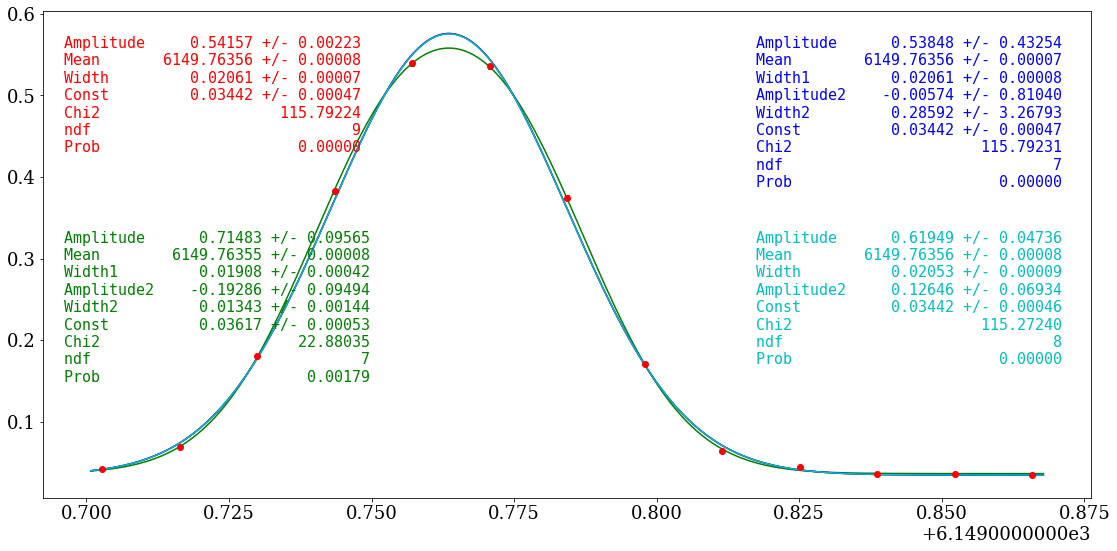

In [9]:
dw = 0.002
# Plot the data:
figPeak, axPeak = plt.subplots(figsize=(16, 8))
#axPeak.errorbar(peak_waves[Nexample], peak_specs[Nexample], peak_especs[Nexample], fmt='ro', ecolor='k', linewidth=1, capsize=2, capthick=1)
axPeak.errorbar(x, y, ey, fmt='ro', ecolor='k', linewidth=1, capsize=2, capthick=1)
xPeak = np.linspace(x[0]-dw, x[len(x)-1]+dw, 500)
axPeak.plot(xPeak, func_GaussConst(xPeak, *minuit.values[:]), '-r')
axPeak.plot(xPeak, func_GaussGaussConst(xPeak, *minuitGG.values[:]), '-g')
axPeak.plot(xPeak, func_GaussEffConst(xPeak, *minuitEff.values[:]), '-b')
axPeak.plot(xPeak, func_GaussEff2Const(xPeak, *minuitEff2.values[:]), '-c')

d = {'Amplitude':[minuit.values['A'], minuit.errors['A']],
     'Mean':     [minuit.values['mu'], minuit.errors['mu']],
     'Width':    [minuit.values['sigma'], minuit.errors['sigma']],
     'Const':    [minuit.values['C'], minuit.errors['C']],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }
text = nice_string_output(d, extra_spacing=2, decimals=5)
add_text_to_ax(0.02, 0.95, text, axPeak, fontsize=15, color='r')

dGG = {'Amplitude': [minuitGG.values['A'], minuitGG.errors['A']],
       'Mean':      [minuitGG.values['mu'], minuitGG.errors['mu']],
       'Width1':    [minuitGG.values['sigma1'], minuitGG.errors['sigma1']],
       'Amplitude2':[minuitGG.values['B'], minuitGG.errors['B']],
       'Width2':    [minuitGG.values['sigma2'], minuitGG.errors['sigma2']],
       'Const':     [minuitGG.values['C'], minuitGG.errors['C']],
       'Chi2':      Chi2_fitGG,
       'ndf':       Ndof_fitGG,
       'Prob':      Prob_fitGG,
      }
textGG = nice_string_output(dGG, extra_spacing=2, decimals=5)
add_text_to_ax(0.02, 0.55, textGG, axPeak, fontsize=15, color='g')

dEff = {'Amplitude': [minuitEff.values['A'], minuitEff.errors['A']],
        'Mean':      [minuitEff.values['mu'], minuitEff.errors['mu']],
        'Width1':    [minuitEff.values['sigma1'], minuitEff.errors['sigma1']],
        'Amplitude2':[minuitEff.values['B'], minuitEff.errors['B']],
        'Width2':    [minuitEff.values['sigma2'], minuitEff.errors['sigma2']],
        'Const':     [minuitEff.values['C'], minuitEff.errors['C']],
        'Chi2':      Chi2_fitEff,
        'ndf':       Ndof_fitEff,
        'Prob':      Prob_fitEff,
       }
textEff = nice_string_output(dEff, extra_spacing=2, decimals=5)
add_text_to_ax(0.68, 0.95, textEff, axPeak, fontsize=15, color='b')

dEff2 = {'Amplitude': [minuitEff2.values['A'], minuitEff2.errors['A']],
         'Mean':      [minuitEff2.values['mu'], minuitEff2.errors['mu']],
         'Width':     [minuitEff2.values['sigma1'], minuitEff2.errors['sigma1']],
         'Amplitude2':[minuitEff2.values['B'], minuitEff2.errors['B']],
         'Const':     [minuitEff2.values['C'], minuitEff2.errors['C']],
         'Chi2':      Chi2_fitEff2,
         'ndf':       Ndof_fitEff2,
         'Prob':      Prob_fitEff2,
       }
textEff2 = nice_string_output(dEff2, extra_spacing=2, decimals=5)
add_text_to_ax(0.68, 0.55, textEff2, axPeak, fontsize=15, color='c')

figPeak.tight_layout()

## Fitting all peaks:

In [10]:
Minuit.print_level = 0

def FlattenList(li):
    return [item for sublist in li for item in sublist]

# Fitting function:
def func2_GaussConst(x, A, mu, sigma, C) :
    # return A / np.sqrt(2*np.pi) / sigma * np.exp(-0.5 * ((x-mu)/sigma)**2 )  +  C
    return A * np.exp(-0.5 * ((x-mu)/sigma)**2 )  +  C

def func2_GaussEffConst(x, A, mu, sigma1, B, sigma2, C) :
    # return A / np.sqrt(2*np.pi) / sigma * np.exp(-0.5 * ((x-mu)/sigma)**2)  +  C
    return A * np.exp(-0.5 * ((x-mu)/sigma1)**2)  *  (1.0 - B * np.exp(-0.5 * ((x-mu)/sigma2)**2))  +  C

# ChiSquare to be minimised (using ExternalFunctions):
# chi2_object = Chi2Regression(fit_function, x, y, ey)

# ChiSquare fit model:
def model2_chi2(A, mu, sigma, C) :
    y_fit = func2_GaussConst(x, A, mu, sigma, C)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2

def model2Eff_chi2(A, mu, sigma1, B, sigma2, C) :
    y_fit = func_GaussEffConst(x, A, mu, sigma1, B, sigma2, C)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2

# Define a general function for fitting peaks:
def func_PeakFit(x, y, ey) :

    """
    A_init     = np.max(y)
    mu_init    = np.mean(x)
    sigma_init = 0.01
    C_init     = 0.5*(y[0] + y[len(x)-1])
    # minuit = Minuit(chi2_object, pedantic=False, A=2.0, mu=mu_init, sigma=sigma_init, print_level=0)     # External Functions
    minuit = Minuit(model2_chi2, pedantic=False, A=A_init, mu=mu_init, sigma=sigma_init, C=C_init, print_level=0)     # Own alternative
    
    # Perform the actual fit (and save the parameters):
    minuit.migrad();                                                  
    minuit_output = [minuit.fmin, minuit.params]    # Save the output parameters in case needed
    
    # Extract the fitting parameters and their uncertainties:
    mu_fit = minuit.values['mu']
    sigma_mu_fit = minuit.errors['mu']

    Npoints = len(x)
    Nvar = 4                            # Number of variables
    Ndof_fit = Npoints - Nvar           # Number of degrees of freedom = Number of data points - Number of variables
    Chi2_fit = minuit.fval                          # The chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

    figPeaks, axPeaks = plt.subplots(figsize=(16, 8))
    axPeaks.errorbar(x, y, ey, fmt='ro', ecolor='k', linewidth=1, capsize=2, capthick=1)
    xPeaks = np.linspace(x[0]-dw, x[len(x)-1]+dw, 500)
    axPeaks.plot(xPeaks, func2_GaussConst(xPeaks, *minuit.args), '-r')

    d = {'Amplitude':[minuit.values['A'], minuit.errors['A']],
         'Mean':     [minuit.values['mu'], minuit.errors['mu']],
         'Width':    [minuit.values['sigma'], minuit.errors['sigma']],
         'Const':    [minuit.values['C'], minuit.errors['C']],
         'Chi2':     Chi2_fit,
         'ndf':      Ndof_fit,
         'Prob':     Prob_fit,
        }

    text = nice_string_output(d, extra_spacing=2, decimals=5)
    add_text_to_ax(0.02, 0.95, text, axPeaks, fontsize=20)
    """

    # ------------------------------------------------------------------------------

    # Fit peak with a Gaussian and an EFFICIENCY function:
    A_init      = 0.45
    mu_init     = np.mean(x)
    sigma1_init = 0.02
    B_init      = 0.10
    sigma2_init = 0.02
    C_init      = 0.02
    # minuit = Minuit(chi2_object, pedantic=False, A=2.0, mu=mu_init, sigma=sigma_init, print_level=0)     # External Functions
    minuitEff = Minuit(model2Eff_chi2, A=A_init, mu=mu_init, sigma1=sigma1_init, B=B_init, sigma2=sigma2_init, C=C_init)     # Own alternative

    # Perform the actual fit (and save the parameters):
    minuitEff.migrad();                                                  
    minuitEff_output = [minuitEff.fmin, minuitEff.params]    # Save the output parameters in case needed
    
    # Extract the fitting parameters and their uncertainties:
    mu_fit = minuitEff.values['mu']
    sigma_mu_fit = minuitEff.errors['mu']

    Npoints = len(x)
    Nvar = 6                            # Number of variables
    Ndof_fitEff = Npoints - Nvar         # Number of degrees of freedom = Number of data points - Number of variables
    Chi2_fitEff = minuitEff.fval                            # The chi2 value
    Prob_fitEff = stats.chi2.sf(Chi2_fitEff, Ndof_fitEff)   # The chi2 probability given N degrees of freedom
    # print(f"  Peak fitted. N = {Npoints:2d}   Chi2 ={Chi2_fit:5.1f}   Wave mean = {mu_fit:8.3f}+-{sigma_mu_fit:5.3f}")

    if (not minuitEff.valid) :
        print("  WARNING: Minuit reports that fit was not VALID!")
    if (not minuitEff.accurate) :
        print("  WARNING: Minuit reports that fit was not ACCURATE!")
    
    figPeaks, axPeaks = plt.subplots(figsize=(16, 8))
    axPeaks.errorbar(x, y, ey, fmt='ro', ecolor='k', linewidth=1, capsize=2, capthick=1)
    xPeaks = np.linspace(x[0]-dw, x[len(x)-1]+dw, 500)
    axPeaks.plot(xPeaks, func2_GaussEffConst(xPeaks, *minuitEff.values[:]), '-r')
    
    dEff = {'Amplitude': [minuitEff.values['A'], minuitEff.errors['A']],
            'Mean':      [minuitEff.values['mu'], minuitEff.errors['mu']],
            'Width1':    [minuitEff.values['sigma1'], minuitEff.errors['sigma1']],
            'Amplitude2':[minuitEff.values['B'], minuitEff.errors['B']],
            'Width2':    [minuitEff.values['sigma2'], minuitEff.errors['sigma2']],
            'Const':     [minuitEff.values['C'], minuitEff.errors['C']],
            'Chi2':      Chi2_fitEff,
            'ndf':       Ndof_fitEff,
            'Prob':      Prob_fitEff,
           }
    textEff = nice_string_output(dEff, extra_spacing=2, decimals=5)
    add_text_to_ax(0.68, 0.95, textEff, axPeak, fontsize=15, color='b')

    
    figPeaks.tight_layout()
    plt.ioff()
    plotfilename = f'FitFigures/FitFig_wavelength{x[0]:8.4f}-{x[len(x)-1]:8.4f}.png'
    plt.savefig(plotfilename)
    plt.close("all")
    
    result = FlattenList([[Chi2_fitEff], minuitEff.values[:], minuitEff.errors[:]])
    return result

  Peak is not full - array too short (or Nfits done!):  6 0


/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_27127/3545114377.py:85: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  minuitEff.migrad();


FileNotFoundError: [Errno 2] No such file or directory: 'FitFigures/FitFig_wavelength6141.0442-6141.1989.png'

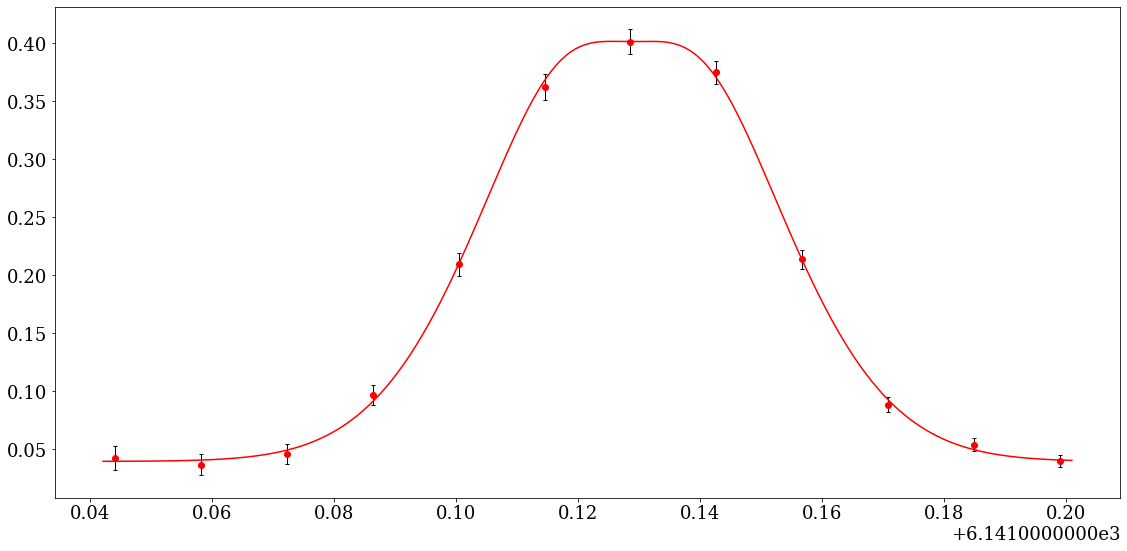

In [11]:
# Fit the peaks with a Gaussian:
Nfits = 0
res_Chi2   = []
res_A      = []
res_mu     = []
res_sigma1 = []
res_B      = []
res_sigma2 = []
res_C      = []

for peak_spec, peak_espec, peak_wave in zip(peak_specs, peak_especs, peak_waves) :
    x = np.array(peak_wave)
    y = np.array(peak_spec)
    ey = np.array(peak_espec)
    if (len(x) > 9 and Nfits < NpeaksMax) :
        Nfits += 1
        fit_result = func_PeakFit(x, y, ey)
        if (Nfits < 2) :
            print(fit_result)
        chi2 = fit_result[0]
        wmean = fit_result[2]
        ewmean = fit_result[2+6]
        
        if (fit_result[4] < -0.4) :
            print("  WARNING: Fit gives significant negative efficiency!", fit_result[4], "  Peak number: ", Nfits)
        print(f"  Peak fitted. N = {len(x):2d}   Chi2 ={chi2:5.1f}   Wave mean = {wmean:9.4f}+-{ewmean:6.4f}")
        res_Chi2.append(chi2)
        res_A.append(fit_result[1])
        res_mu.append(fit_result[2])
        res_sigma1.append(fit_result[3])
        res_B.append(fit_result[4])
        res_sigma2.append(fit_result[5])
        res_C.append(fit_result[6])

    else :
        print("  Peak is not full - array too short (or Nfits done!): ", len(x), Nfits)

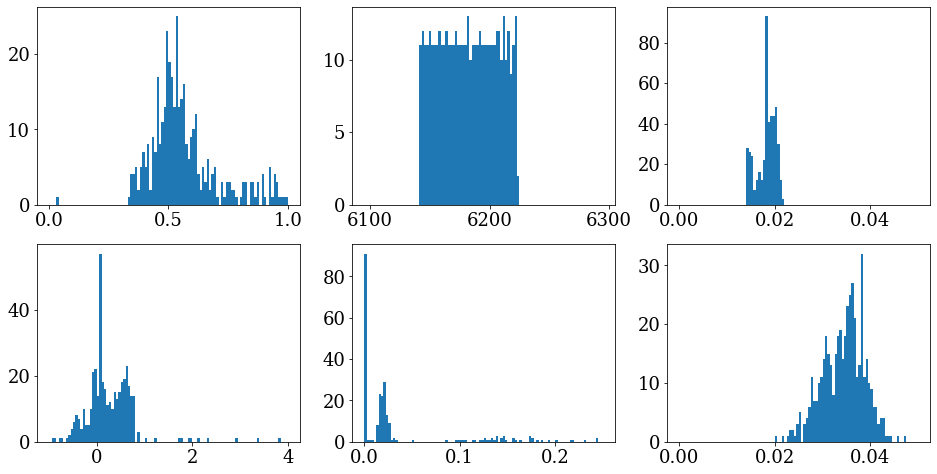

In [ ]:
# Plotting fit values as a function of peaks (to enable good starting values):

fig2, ax2 = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
ax2[0,0].hist(res_A, bins=100, range=(0.0, 1.0))
ax2[0,1].hist(res_mu, bins=100, range=(6095.0, 6295.0))
ax2[0,2].hist(res_sigma1, bins=100, range=(0.0, 0.05))
ax2[1,0].hist(res_B, bins=100, range=(-1.0, 4.0))
ax2[1,1].hist(res_sigma2, bins=100, range=(0.0, 0.25))
ax2[1,2].hist(res_C, bins=100, range=(0.0, 0.05))
plt.show()

0.7666666666666667 -0.10133333333333333


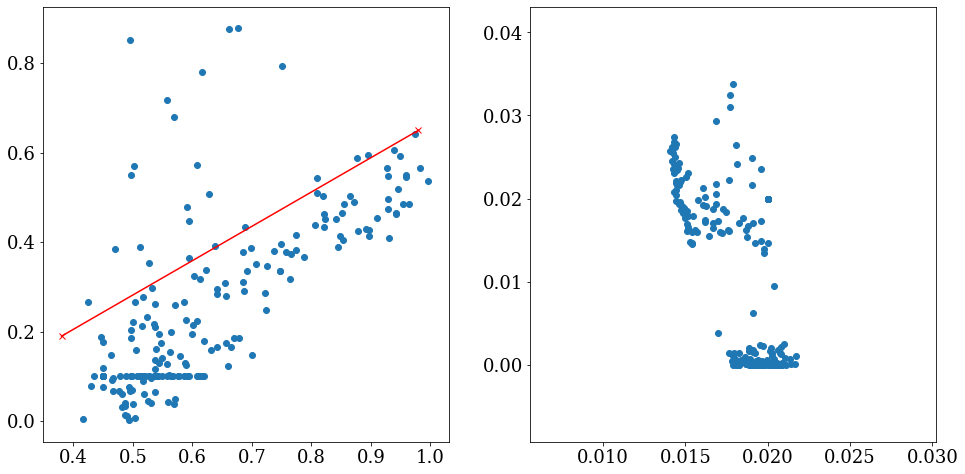

In [ ]:
# Plotting fit value corrlations (to see how degenerate some of the paramters are):

fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
x1 = [0.38, 0.98]
y1 = [0.19, 0.65]
a = (y1[1]-y1[0]) / (x1[1]-x1[0])
b = y1[0] - x1[0] * a
print(a, b)
ax3[0].plot(x1, y1, marker = 'x', color='r')
ax3[0].scatter(ma.masked_outside(res_A, 0.0, 1.0), ma.masked_outside(res_B, 0.0, 1.0))
ax3[1].scatter(ma.masked_outside(res_sigma1, 0.014, 0.023), ma.masked_outside(res_sigma2, 0.0, 0.04))
plt.show()

# Produce report of fitting results:

The quality of the raw data, peak finding, and fitting results can be summarised as follows:
1. Number of NaNs (test of raw data).
2. Number of peaks above length 9, and fraction out of total entries (test of peak finding).
3. Number and fraction of peaks with valid and accurate fit.
4. Number and fraction of peaks with a "reasonable" p-value from Chi2 fit.
5. Distributions of fitting values, not the least uncertainty on mean and difference between mean and "truth".

# Apply calibration and determine goodness:

Using the true and fitted peak values, quantify the goodness of the calibration.

This part needs a closer definition.